# How to run Qiskit on Amazon Braket

In [ ]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

If you're like many people who learned quantum computing in the past several years, you might have learned how to program quantum circuits with [Qiskit](https://qiskit.org): the open-source quantum Software Development Kit (SDK) first released in 2017. With the [Qiskit-Braket provider](https://github.com/qiskit-community/qiskit-braket-provider/blob/main/docs/tutorials/0_tutorial_qiskit-braket-provider_overview.ipynb), you can run your Qiskit code across any of the gate-based devices on the [Amazon Braket](https://aws.amazon.com/braket/) quantum computing service.

**Note**: if you're running this in your local development environment (i.e. not from the Braket console), you'll need to make sure you've got your AWS account configured properly first to access Braket devices. Check out [this tutorial](https://aws.amazon.com/blogs/quantum-computing/setting-up-your-local-development-environment-in-amazon-braket/) for a walkthrough.

## Access Braket devices from Qiskit 

 There are quite a few different backend devices on Amazon Braket, so we'll walk through them one by one and give an example of recommended use cases for each.

### Quantum simulators
Let's start with the ***local simulator***. This is a quantum full state vector simulator which runs *locally* -- that means wherever you're running this Jupyter notebook (e.g. your local development environment or a notebook instance on the Braket console).

**Recommended use case:** Noiseless circuits up to ~12 qubits

In [ ]:
from qiskit_braket_provider import BraketLocalBackend

local_simulator = BraketLocalBackend()

Next, we have the ***local density matrix simulator***. This simulator also runs on your local machine, but allows you to simulate the effects of *noise* on your quantum circuit. Because density matrices are twice the size of state vectors, the number of qubits you can effectively simulate is half the size as the local state vector simulator.

**Recommended use case:** Noisy circuits up to ~6 qubits

In [ ]:
local_dm_simulator = BraketLocalBackend(name='braket_dm')

Now let's look at Braket's *on-demand* simulators: these run on AWS computing resources and have some expanded features in addition to those of the local simulator. We can list all the available Braket simulators with the following code:

In [ ]:
from qiskit_braket_provider import BraketProvider

provider = BraketProvider()

provider.backends(statuses=["ONLINE"], types=["SIMULATOR"])

First up for on-demand simulators is ***SV1***. This is a full state vector simulator which allows you to simulate larger circuits than the local simulator, along with the ability to [batch tasks](https://docs.aws.amazon.com/braket/latest/developerguide/braket-batching-tasks.html) and run them in parallel, as well as use advanced techniques like [adjoint gradient calculations](https://pennylane.ai/blog/2022/12/computing-adjoint-gradients-with-amazon-braket-sv1/) for variational quantum algorithms. 

**Recommended use case:** Noiseless variational algorithms on up to 34 qubits

In [ ]:
sv1 = provider.get_backend("SV1")

The next on-demand simulator is ***DM1***. This is a density matrix simulator which, like SV1, allows you to simulate a larger number of qubits, as well as take advantage of batch execution. 

**Recommended use case:** Noisy variational algorithms on up to 17 qubits

In [ ]:
dm1 = provider.get_backend("dm1")

Lastly for on-demand simulators, we have ***TN1***. This is a tensor-network simulator, which represents each gate in a circuit as a tensor. TN1 can simulate a larger number of qubits for circuits with local gates or other special structure, but will typically be slower than SV1 or DM1 for circuits with long-range or all-to-all gate structure.

**Recommended use case:** Noiseless quantum circuits with local connectivity and up to 50 qubits

**Note**: Each AWS resource, (like a file or CPU or QPU) lives in a specific region and may only be accessible from that region. For example, TN1 is only available in the `eu-west-2`, `us-east-1`, and `us-west-2` regions. 

To change your AWS region if you're running in a managed notebook, you'll need to use the GUI in the top right hand corner of the AWS console to select your new region, then relaunch or create your notebook from the Braket console.

To change your AWS region if you're running in your local development environment, you run the following code snippet:
```
import os
os.environ["AWS_REGION"] = "your-desired-region"
```

In [ ]:
# If you've switched to one of the regions where TN1 is accessible, feel free to uncomment the following code
# tn1 = provider.get_backend("TN1")

### Quantum Processing Units (QPUs)

Amazon Braket also provides access to a number of third-party quantum hardware devices. The following code shows how to view the supported QPUs which are currently online:

In [ ]:
provider.backends(statuses=["ONLINE"], types=["QPU"])

For a closer look at each quantum computer, you can peruse the [Providers Overview](https://aws.amazon.com/braket/quantum-computers/) on the Braket homepage, or the Devices tab on the left side of the Braket console. 
Currently only gate-based QPUs (IonQ, Rigetti) are supported with the Qiskit-Braket provider. 

## Running circuits on Braket devices



Now that we've walked through each of the quantum devices available through the Qiskit-Braket provider, let's take them for a spin! For this example, we'll create a 3-GHZ state on the Rigetti device, but feel free to choose a different QPU from the commented out devices below.

In [ ]:
qpu_backend = provider.get_backend("Aspen-M-3")
# qpu_backend = provider.get_backend("Aria")

print(qpu_backend)

In [ ]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(0, 2)
circuit.draw()

In [ ]:
# run circuit
qpu_task = qpu_backend.run(circuit, shots=10)

Each quantum task you run is assigned a unique ARN (Amazon Resource Name), which you can save and use to retrieve the data for your quantum task after its run, even if you close your notebook.

In [ ]:
task_id = qpu_task.task_id()
task_id

Now, Braket has a separate feature called \"Hybrid *Jobs*\", which is beyond the scope of this notebook, but which you can read about in the [developer guide](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs.html).

In [ ]:
# Retrieve quantum task data
retrieved_task = qpu_backend.retrieve_job(task_id=task_id)

Then you can check the status of the task to see if it's finished:

In [ ]:
retrieved_task.status()

**Note:** different devices may have different availability windows, so while your task may not run right away, rest assured it will be added to the queue to be run when the device is back online.

When your task is finished, you can retrieve the data:

In [ ]:
data = retrieved_task.result()

In [ ]:
from qiskit.visualization import plot_histogram
plot_histogram(data.get_counts())

## Running algorithms on Braket devices

You can also use the Qiskit-Braket provider to run built-in Qiskit algorithms on Braket backends. For example, we can run the VQE algorithm to find the ground state of hydrogen. We'll use the local simulator since the problem can be expressed in a basis that only requires a few qubits and will run quickly.

In [ ]:
from qiskit.quantum_info import SparsePauliOp

# Define the Hamiltonian operator for H2 in terms of Pauli spin operators
H2_op = SparsePauliOp.from_list([('II', -1.052373245772859), ('IZ', 0.39793742484318045), ('ZI', -0.39793742484318045), ('ZZ', -0.01128010425623538), ('XX', 0.18093119978423156)])

In [ ]:
# Import some utilities
from qiskit.primitives import BackendEstimator
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SLSQP
from qiskit_algorithms import VQE

# Define a `BackendEstimator` with a Braket backend
qi = BackendEstimator(local_simulator, options={'seed_simulator':42})
qi.set_transpile_options(seed_transpiler=42)

# Specify VQE configuration
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
slsqp = SLSQP(maxiter=1)
vqe = VQE(estimator=qi, ansatz=ansatz, optimizer=slsqp)

# Find the ground state
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

## What now?

The sky is the limit! Keep in mind, the Qiskit-Braket provider is still new and experimental, so if you run into a bug or want a new feature supported, consider [submitting a GitHub issue](https://github.com/qiskit-community/qiskit-braket-provider/issues) and opening a feature branch to join in on the development effort yourself!

In [ ]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

In [1]:
!pip install qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 71.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 32.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 15.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 38.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 20.3 MB/s eta 0:00:00


In [2]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 22.8 MB/s eta 0:00:0000:010:01m


In [3]:
!pip install qiskit-machine-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 1.8 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 2.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 17.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 1.6 MB/s eta 0:00:00:00:01
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=106097 sha256=0322351ae4df3ed8c619dedb01e3f216f8dc3a385ca0dc62ec33601e7d505a13
  Stored in directory: /home/ec2-user/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [4]:
!pip install amazon-braket-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.7/313.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 1.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.8/539.8 kB 7.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.7/191.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.9/423.9 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/6

In [5]:
!pip install pandas

In [6]:
!pip install numpy

In [7]:
!pip install scikit-learn

In [8]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 45.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 3.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 32.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 97.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 18.4 MB/s eta 0:00:00


In [9]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.5.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.10/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: qiskit-machine-learning


Explained variance ratio: [0.7070102  0.24507687]


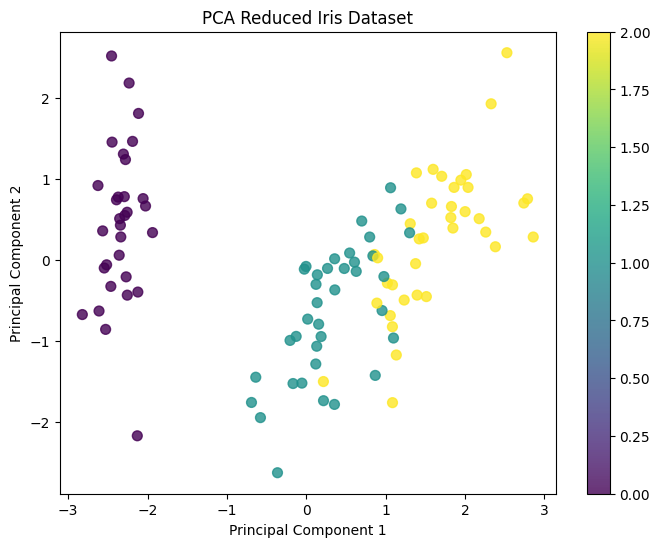

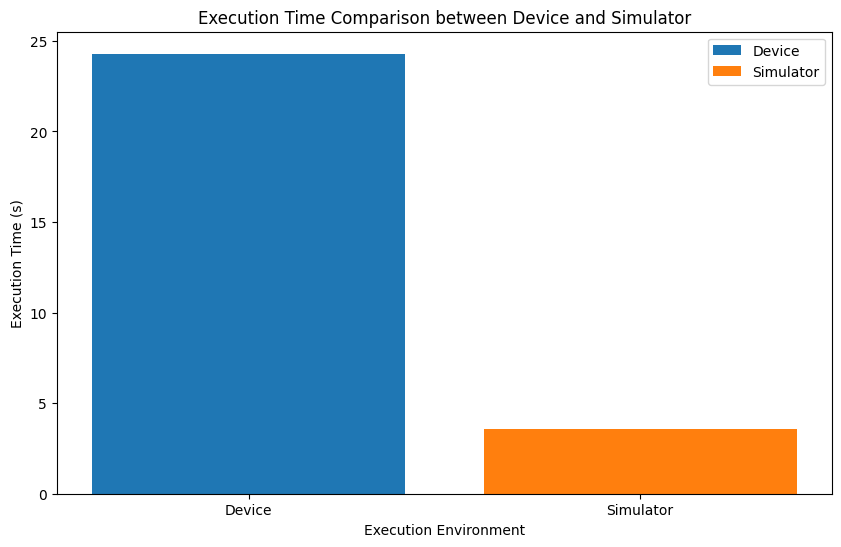

Device Execution Times: [20.25355100631714, 21.21524167060852, 24.29136347770691, 21.980304718017578, 19.34014916419983]
Simulator Execution Times: [3.5548629760742188, 1.6984992027282715, 2.6389079093933105, 2.659008264541626, 2.702792167663574]
Device Metrics: [None, None, None, None, None]
Simulator Metrics: [None, None, None, None, None]


In [20]:
import sys
sys.path.insert(0, '/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.10/site-packages')

import numpy as np
from braket.aws import AwsDevice, AwsQuantumTask, AwsSession
from braket.circuits import Circuit
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Setup AWS session
aws_session = AwsSession()


# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for feature reduction
pca = PCA(n_components=2)  # Reduce to 2 principal components for demonstration
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

# Example of variance explained by principal components
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Visualize the reduced dataset (optional)
plt.figure(figsize=(8, 6))
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train, cmap='viridis', s=50, alpha=0.8)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Reduced Iris Dataset')
plt.colorbar()
plt.show()

# Now X_train_reduced and X_test_reduced contain reduced feature sets

# Function to create a quantum SVM circuit
def create_quantum_svm_circuit(feature_map, train_data, test_data):
    circuit = Circuit()

    # Feature map construction
    feature_map.construct_circuit(circuit, train_data)

    # Insert quantum gates for SVM
    # Example: Here you would define your quantum SVM algorithm using Qiskit, PennyLane, or other quantum computing libraries

    return circuit


# Define feature map (example, can be replaced with actual quantum feature map)
class QuantumFeatureMap:
    def __init__(self):
        pass

    def construct_circuit(self, circuit, data):
        # Example: apply Hadamard gate to each qubit for each feature
        for i in range(data.shape[1]):
            circuit.h(i)

# Initialize AWS Quantum Device
device_arn = "arn:aws:braket:us-east-1::device/qpu/ionq/Aria-2"  # Example device ARN
device = AwsDevice(device_arn)

# Simulate on the device
results_device = []
execution_times_device = []

for i in range(5):  # Run 5 times for averaging
    start_time = time.time()
    # Create circuit
    quantum_circuit_device = create_quantum_svm_circuit(QuantumFeatureMap(), X_train_scaled, X_test_scaled)

    # Execute on device
    task_device = device.run(quantum_circuit_device, shots=1000)
    results_device.append(task_device.result())

    execution_time = time.time() - start_time
    execution_times_device.append(execution_time)

# Simulate on the simulator
simulator = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
results_simulator = []
execution_times_simulator = []

for i in range(5):  # Run 5 times for averaging
    start_time = time.time()

    # Create circuit
    quantum_circuit_simulator = create_quantum_svm_circuit(QuantumFeatureMap(), X_train_scaled, X_test_scaled)

    # Execute on simulator
    task_simulator = simulator.run(quantum_circuit_simulator, shots=1000)
    results_simulator.append(task_simulator.result())

    execution_time = time.time() - start_time
    execution_times_simulator.append(execution_time)
    
# Process results (adjusted to handle Braket's result format)
def process_results(results):
    metrics = []
    for result in results:
        if 'estimation_stats' in result.additional_metadata:
            metric = result.additional_metadata['estimation_stats']
            metrics.append(metric)
        else:
            # Handle case where estimation_stats is not found
            metrics.append(None)  # or any default value as per your needs
    return metrics


metrics_device = process_results(results_device)
metrics_simulator = process_results(results_simulator)

# Example: Plotting execution times
plt.figure(figsize=(10, 6))
plt.bar(['Device'] * 5, execution_times_device, label='Device')
plt.bar(['Simulator'] * 5, execution_times_simulator, label='Simulator')
plt.xlabel('Execution Environment')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time Comparison between Device and Simulator')
plt.legend()
plt.show()

# Example: Numerical comparison of efficiency and accuracy
print("Device Execution Times:", execution_times_device)
print("Simulator Execution Times:", execution_times_simulator)
print("Device Metrics:", metrics_device)
print("Simulator Metrics:", metrics_simulator)

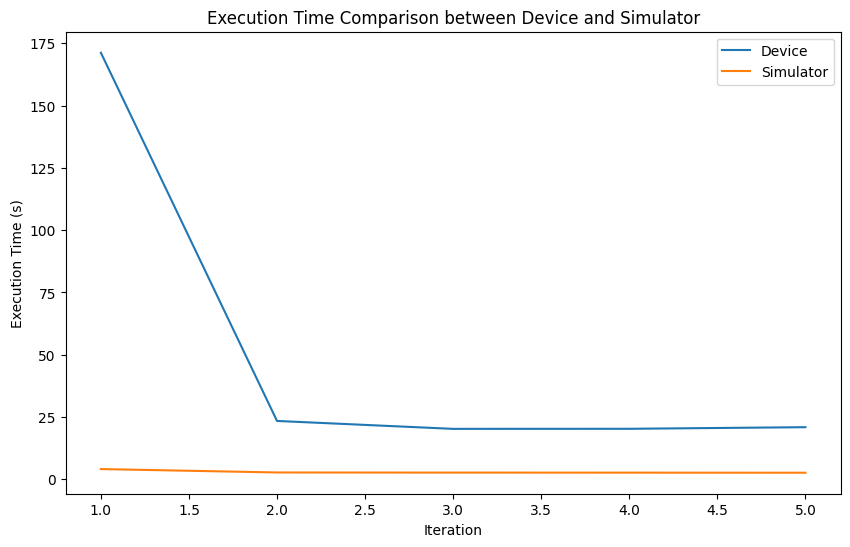

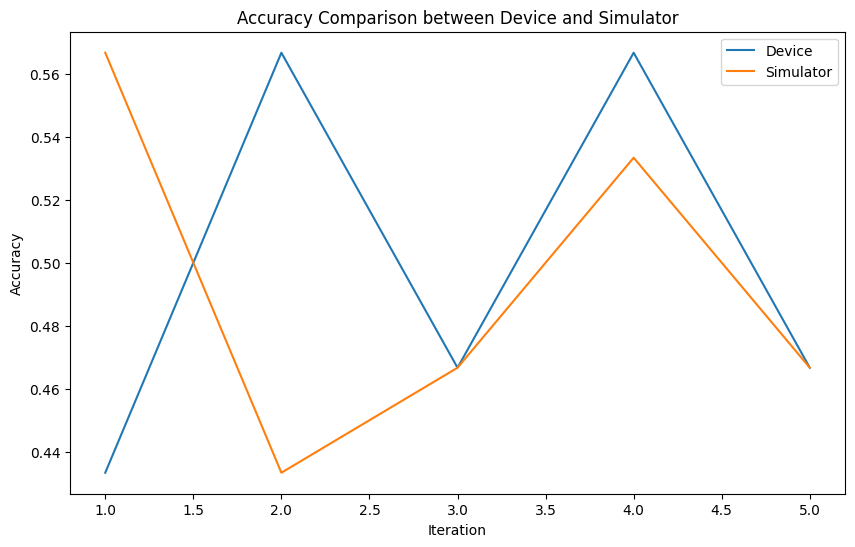

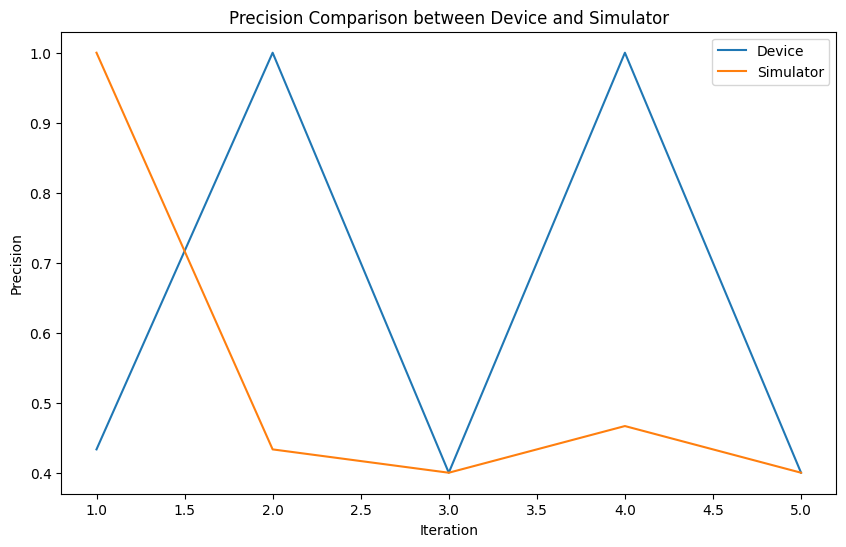

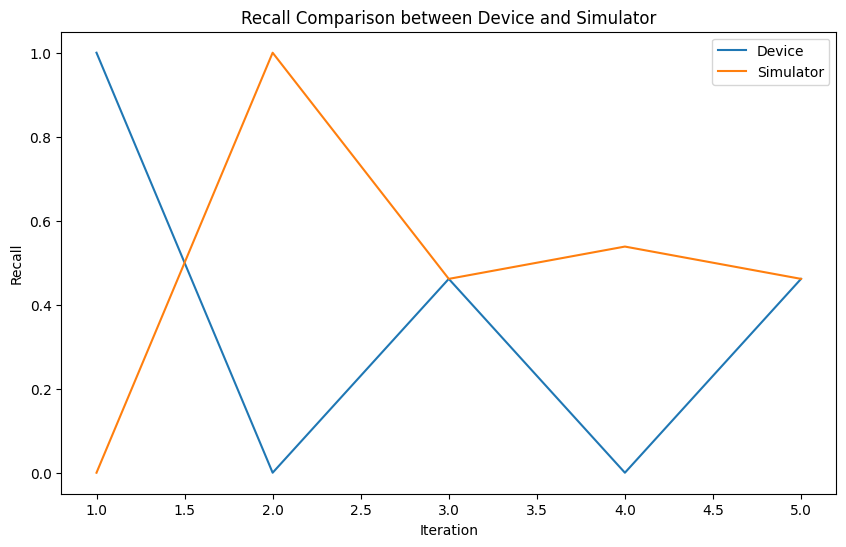

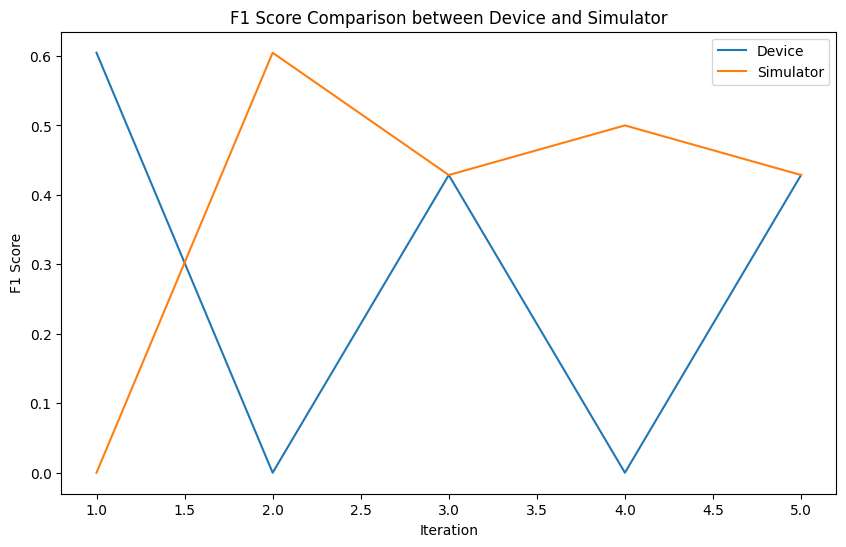

Device Execution Times: [171.22746300697327, 23.410552740097046, 20.23383617401123, 20.262943744659424, 20.908539295196533]
Simulator Execution Times: [4.093458414077759, 2.7285537719726562, 2.6778159141540527, 2.6607003211975098, 2.6273577213287354]
Device Accuracies: [0.43333333333333335, 0.5666666666666667, 0.4666666666666667, 0.5666666666666667, 0.4666666666666667]
Simulator Accuracies: [0.5666666666666667, 0.43333333333333335, 0.4666666666666667, 0.5333333333333333, 0.4666666666666667]
Device Precisions: [0.43333333333333335, 1.0, 0.4, 1.0, 0.4]
Simulator Precisions: [1.0, 0.43333333333333335, 0.4, 0.4666666666666667, 0.4]
Device Recalls: [1.0, 0.0, 0.46153846153846156, 0.0, 0.46153846153846156]
Simulator Recalls: [0.0, 1.0, 0.46153846153846156, 0.5384615384615384, 0.46153846153846156]
Device F1 Scores: [0.6046511627906976, 0.0, 0.42857142857142855, 0.0, 0.42857142857142855]
Simulator F1 Scores: [0.0, 0.6046511627906976, 0.42857142857142855, 0.5, 0.42857142857142855]
Device Metric

In [17]:
import sys
sys.path.insert(0, '/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.10/site-packages')

import numpy as np
from braket.aws import AwsDevice, AwsQuantumTask, AwsSession
from braket.circuits import Circuit
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import matplotlib.pyplot as plt
from collections import Counter

# Setup AWS session
aws_session = AwsSession()

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Filter only two classes for binary classification (quantum SVMs typically work with binary classification)
binary_class_indices = np.where(y != 2)
X = X[binary_class_indices]
y = y[binary_class_indices]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for feature reduction
pca = PCA(n_components=2)  # Reduce to 2 principal components for demonstration
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

# Define feature map (example, can be replaced with actual quantum feature map)
class QuantumFeatureMap:
    def __init__(self):
        pass

    def construct_circuit(self, circuit, data):
        # Example: apply Hadamard gate to each qubit for each feature
        for i in range(data.shape[1]):
            circuit.h(i)

# Function to create a quantum SVM circuit
def create_quantum_svm_circuit(feature_map, train_data):
    circuit = Circuit()
    # Feature map construction
    feature_map.construct_circuit(circuit, train_data)
    # Insert quantum gates for SVM
    # Example: Here you would define your quantum SVM algorithm using Qiskit, PennyLane, or other quantum computing libraries
    return circuit

# Initialize AWS Quantum Device
device_arn = "arn:aws:braket:us-east-1::device/qpu/ionq/Aria-2"  # Example device ARN
device = AwsDevice(device_arn)

# Simulate on the device
results_device = []
execution_times_device = []
device_accuracies = []
device_precisions = []
device_recalls = []
device_f1_scores = []

for i in range(5):  # Run 5 times for averaging
    start_time = time.time()
    # Create circuit
    quantum_circuit_device = create_quantum_svm_circuit(QuantumFeatureMap(), X_train_reduced)

    # Execute on device
    task_device = device.run(quantum_circuit_device, shots=1000)
    results_device.append(task_device.result())

    execution_time = time.time() - start_time
    execution_times_device.append(execution_time)

    # Calculate accuracy for device results
    device_counts = Counter(task_device.result().measurement_counts)
    most_common_device = device_counts.most_common(1)[0][0]  # Simplified accuracy calculation
    # Map the measurement result to the binary labels
    device_labels = np.array([int(bit) for bit in most_common_device] * (len(y_test) // len(most_common_device)))
    if len(device_labels) < len(y_test):
        device_labels = np.append(device_labels, [int(most_common_device[-1])] * (len(y_test) - len(device_labels)))
    device_accuracy = accuracy_score(y_test, device_labels)
    device_precision = precision_score(y_test, device_labels, zero_division=1)
    device_recall = recall_score(y_test, device_labels, zero_division=1)
    device_f1 = f1_score(y_test, device_labels, zero_division=1)
    device_accuracies.append(device_accuracy)
    device_precisions.append(device_precision)
    device_recalls.append(device_recall)
    device_f1_scores.append(device_f1)

# Simulate on the simulator
simulator = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
results_simulator = []
execution_times_simulator = []
simulator_accuracies = []
simulator_precisions = []
simulator_recalls = []
simulator_f1_scores = []

for i in range(5):  # Run 5 times for averaging
    start_time = time.time()

    # Create circuit
    quantum_circuit_simulator = create_quantum_svm_circuit(QuantumFeatureMap(), X_train_reduced)

    # Execute on simulator
    task_simulator = simulator.run(quantum_circuit_simulator, shots=1000)
    results_simulator.append(task_simulator.result())

    execution_time = time.time() - start_time
    execution_times_simulator.append(execution_time)

    # Calculate accuracy for simulator results
    simulator_counts = Counter(task_simulator.result().measurement_counts)
    most_common_simulator = simulator_counts.most_common(1)[0][0]  # Simplified accuracy calculation
    # Map the measurement result to the binary labels
    simulator_labels = np.array([int(bit) for bit in most_common_simulator] * (len(y_test) // len(most_common_simulator)))
    if len(simulator_labels) < len(y_test):
        simulator_labels = np.append(simulator_labels, [int(most_common_simulator[-1])] * (len(y_test) - len(simulator_labels)))
    simulator_accuracy = accuracy_score(y_test, simulator_labels)
    simulator_precision = precision_score(y_test, simulator_labels, zero_division=1)
    simulator_recall = recall_score(y_test, simulator_labels, zero_division=1)
    simulator_f1 = f1_score(y_test, simulator_labels, zero_division=1)
    simulator_accuracies.append(simulator_accuracy)
    simulator_precisions.append(simulator_precision)
    simulator_recalls.append(simulator_recall)
    simulator_f1_scores.append(simulator_f1)

# Process results (adjusted to handle Braket's result format)
def process_results(results):
    metrics = []
    for result in results:
        if 'estimation_stats' in result.additional_metadata:
            metric = result.additional_metadata['estimation_stats']
            metrics.append(metric)
        else:
            # Handle case where estimation_stats is not found
            metrics.append(None)  # or any default value as per your needs
    return metrics

metrics_device = process_results(results_device)
metrics_simulator = process_results(results_simulator)

# Plotting execution times
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), execution_times_device, label='Device')
plt.plot(range(1, 6), execution_times_simulator, label='Simulator')
plt.xlabel('Iteration')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time Comparison between Device and Simulator')
plt.legend()
plt.show()

# Plotting accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), device_accuracies, label='Device')
plt.plot(range(1, 6), simulator_accuracies, label='Simulator')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison between Device and Simulator')
plt.legend()
plt.show()

# Plotting precisions
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), device_precisions, label='Device')
plt.plot(range(1, 6), simulator_precisions, label='Simulator')
plt.xlabel('Iteration')
plt.ylabel('Precision')
plt.title('Precision Comparison between Device and Simulator')
plt.legend()
plt.show()

# Plotting recalls
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), device_recalls, label='Device')
plt.plot(range(1, 6), simulator_recalls, label='Simulator')
plt.xlabel('Iteration')
plt.ylabel('Recall')
plt.title('Recall Comparison between Device and Simulator')
plt.legend()
plt.show()

# Plotting F1 scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), device_f1_scores, label='Device')
plt.plot(range(1, 6), simulator_f1_scores, label='Simulator')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison between Device and Simulator')
plt.legend()
plt.show()

# Numerical comparison of efficiency and accuracy
print("Device Execution Times:", execution_times_device)
print("Simulator Execution Times:", execution_times_simulator)
print("Device Accuracies:", device_accuracies)
print("Simulator Accuracies:", simulator_accuracies)
print("Device Precisions:", device_precisions)
print("Simulator Precisions:", simulator_precisions)
print("Device Recalls:", device_recalls)
print("Simulator Recalls:", simulator_recalls)
print("Device F1 Scores:", device_f1_scores)
print("Simulator F1 Scores:", simulator_f1_scores)
print("Device Metrics:", metrics_device)
print("Simulator Metrics:", metrics_simulator)
